In [51]:
import cv2
from ReadCameraModel import ReadCameraModel
from UndistortImage import UndistortImage
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import math

## K Matrix

In [2]:
def cameraMatrix(file):
    frames1 = []
    for frames in os.listdir(file):
        frames1.append(frames)
    fx, fy, cx, cy, G_camera_frames, LUT = ReadCameraModel('model/')
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    return K, LUT

In [3]:
file = "stereo/centre/"
k, LUT = cameraMatrix(file)

## SAMPLE IMAGES

In [4]:
img1=cv2.imread('22.png')
img2=cv2.imread('23.png')


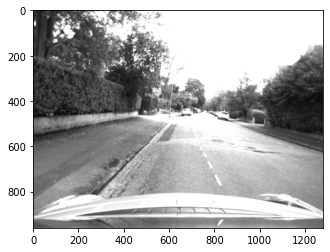

In [5]:
plt.imshow(img1)

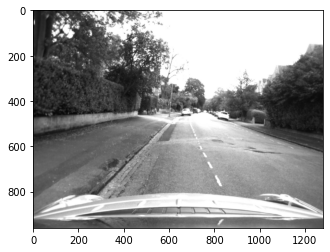

In [6]:
plt.imshow(img2)

## SIFT

In [7]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [8]:
sift = cv2.xfeatures2d.SIFT_create()
(kps1, des1) = sift.detectAndCompute(gray1, None)
print("# kps: {}, descriptors: {}".format(len(kps1), des1.shape))


# kps: 5768, descriptors: (5768, 128)


In [9]:
sift = cv2.xfeatures2d.SIFT_create()
(kps2, des2) = sift.detectAndCompute(gray2, None)
print("# kps: {}, descriptors: {}".format(len(kps2), des2.shape))


# kps: 4914, descriptors: (4914, 128)


In [10]:
img=cv2.drawKeypoints(gray2,kps2,img2)

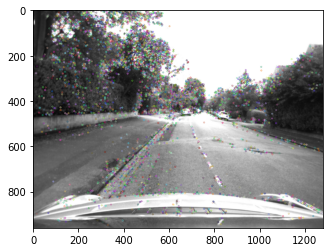

In [11]:
plt.imshow(img)

# FEATURE MATCHING

In [12]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [16]:
features1 = []
features2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.5*n.distance:
        features1.append(kps1[m.queryIdx].pt)
        features2.append(kps2[m.trainIdx].pt)


## Open CV Method

In [17]:
pts1 = np.int32(features1)
pts2 = np.int32(features2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)


In [18]:
F

array([[ 5.65354788e-06,  4.86439493e-03, -2.31046294e+00],
       [-4.86220916e-03,  6.48874292e-07,  2.78397953e+00],
       [ 2.30199797e+00, -2.78133603e+00,  1.00000000e+00]])

In [19]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [20]:
E = k.T @ F @ k


In [21]:
E

array([[ 5.26285922e+00,  4.52824072e+03,  4.77865516e+01],
       [-4.52620599e+03,  6.04033807e-01, -3.33771187e+02],
       [-4.79088801e+01,  3.38285922e+02,  7.97956426e-03]])

In [22]:
retval, R, t, mask = cv2.recoverPose(E, pts1, pts2, k)


In [23]:
R

array([[ 9.99999325e-01, -6.50267468e-04, -9.62458788e-04],
       [ 6.50117983e-04,  9.99999777e-01, -1.55620831e-04],
       [ 9.62559768e-04,  1.54995014e-04,  9.99999525e-01]])

In [24]:
t

array([[ 0.07449259],
       [ 0.01064138],
       [-0.99716479]])

## VOM

In [26]:
def fundamentalMatrix(edge1, edge2): 
    A_x = np.empty((8, 9))

    for i in range(0, len(edge1)):
        x_1 = edge1[i][0]
        y_1 = edge1[i][1]
        x_2 = edge2[i][0]
        y_2 = edge2[i][1]
        A_x[i] = np.array([x_1*x_2, x_2*y_1, x_2, y_2*x_1, y_2*y_1, y_2, x_1, y_1, 1])

    u, s, v = np.linalg.svd(A_x, full_matrices=True)  
    f = v[-1].reshape(3,3)
    u1,s1,v1 = np.linalg.svd(f) 
    s2 = np.array([[s1[0], 0, 0], [0, s1[1], 0], [0, 0, 0]])
    F = u1 @ s2 @ v1    
    return F  

def FmatrixCond(x1,x2,F): 
    x11=np.array([x1[0],x1[1],1]).T
    x22=np.array([x2[0],x2[1],1])
    return abs(np.squeeze(np.matmul((np.matmul(x22,F)),x11)))

Total_inliers = 0
FinalFundamentalMatrix = np.zeros((3,3))
inlier1 = []
inlier2 = []
print('ransac start')
for i in range(0, 50):
    count = 0
    Extracted_points = []
    Frame1_features = []
    Frame2_features = []
    TemporaryFeatures_1 = []
    TemporaryFeatures_2 = []

    while(True):
        num = np.random.randint(0, len(features1)-1)
        if num not in Extracted_points:
            Extracted_points.append(num)
        if len(Extracted_points) == 8:
            break

    for point in Extracted_points:
        Frame1_features.append([features1[point][0], features1[point][1]])
        Frame2_features.append([features2[point][0], features2[point][1]])

    FundMatrix = fundamentalMatrix(Frame1_features, Frame2_features)

    for number in range(0, len(features1)):
        if FmatrixCond(features1[number], features2[number], FundMatrix) < 0.01:
            count = count + 1
            TemporaryFeatures_1.append(features1[number])
            TemporaryFeatures_2.append(features2[number])

    if count > Total_inliers:
        Total_inliers = count
        FinalFundamentalMatrix = FundMatrix
        inlier1 = TemporaryFeatures_1
        inlier2 = TemporaryFeatures_2
print('ransac end')

ransac start
ransac end


In [27]:
FinalFundamentalMatrix

array([[-1.40625968e-07,  8.14475852e-04, -3.03685529e-01],
       [-8.13635078e-04,  1.47031213e-06,  5.27525496e-01],
       [ 3.03068489e-01, -5.28749030e-01,  5.08000570e-01]])

## Essential Matrix

In [28]:
def Essentialmatrix(calibrationMatrix, Fmatrix):
    tempM = np.matmul(np.matmul(calibrationMatrix.T, Fmatrix), calibrationMatrix)
    u, s, v = np.linalg.svd(tempM, full_matrices=True)
    S_F = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
    flag = np.matmul(u, S_F)
    E_matrix = np.matmul(flag, v)
    return E_matrix

In [30]:
E_matrix = Essentialmatrix(k, FinalFundamentalMatrix)

In [31]:
E_matrix

array([[ 8.52023172e-04,  9.93384493e-01,  1.14729328e-01],
       [-9.93310525e-01,  7.83477825e-04,  5.48759525e-03],
       [-1.15344447e-01, -4.77807080e-03,  7.48607268e-05]])

In [41]:
def CamPosematrix(E_matrix):
    u, s, v = np.linalg.svd(E_matrix, full_matrices=True)
    w = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    
    c1 = u[:, 2]
    r1 = u @ w @ v
    
    if np.linalg.det(r1) < 0:
        c1 = -c1 
        r1 = -r1
    c1 = c1.reshape((3,1))
    
    c2 = -u[:, 2]
    r2 = u @ w @ v
    if np.linalg.det(r2) < 0:
        c2 = -c2 
        r2 = -r2 
    c2 = c2.reshape((3,1))
    
    c3 = u[:, 2]
    r3 = u @ w.T @ v
    if np.linalg.det(r3) < 0:
        c3 = -c3 
        r3 = -r3 
    c3 = c3.reshape((3,1)) 
    
    c4 = -u[:, 2]
    r4 = u @ w.T @ v
    if np.linalg.det(r4) < 0:
        c4 = -c4 
        r4 = -r4 
    c4 = c4.reshape((3,1))
    
    return [r1, r2, r3, r4], [c1, c2, c3, c4]

In [42]:
RotationMatrix, Tlist = CamPosematrix(E_matrix)

In [43]:
RotationMatrix[0]

array([[-9.99946940e-01, -3.31470093e-04,  1.02960178e-02],
       [-2.03045453e-03, -9.73532593e-01, -2.28539205e-01],
       [ 1.00992629e-02, -2.28547984e-01,  9.73480264e-01]])

In [35]:
Tlist

[array([[-0.0048687 ],
        [ 0.11534068],
        [-0.99331406]]),
 array([[ 0.0048687 ],
        [-0.11534068],
        [ 0.99331406]]),
 array([[-0.0048687 ],
        [ 0.11534068],
        [-0.99331406]]),
 array([[ 0.0048687 ],
        [-0.11534068],
        [ 0.99331406]])]

In [46]:
def obtainEulerAngles(rot_mat) :
    eu1 = math.sqrt(rot_mat[0,0] * rot_mat[0,0] +  rot_mat[1,0] * rot_mat[1,0])
    singular_val = eu1 < 1e-6
 
    if  not singular_val :
        x = math.atan2(rot_mat[2,1] , rot_mat[2,2])
        y = math.atan2(-rot_mat[2,0], eu1)
        z = math.atan2(rot_mat[1,0], rot_mat[0,0])
    else :
        x = math.atan2(-rot_mat[1,2], rot_mat[1,1])
        y = math.atan2(-rot_mat[2,0], eu1)
        z = 0
    return np.array([x*180/math.pi, y*180/math.pi, z*180/math.pi])

In [47]:
def getTriangulationPoint(m1, m2, point1, point2):
    oldx = np.array([[0, -1, point1[1]], [1, 0, -point1[0]], [-point1[1], point1[0], 0]])
    oldxdash = np.array([[0, -1, point2[1]], [1, 0, -point2[0]], [-point2[1], point2[0], 0]])
    A1 = oldx @ m1[0:3, :] 
    A2 = oldxdash @ m2
    A_x = np.vstack((A1, A2))
    u, s, v = np.linalg.svd(A_x)
    new1X = v[-1]
    new1X = new1X/new1X[3]
    new1X = new1X.reshape((4,1))
    return new1X[0:3].reshape((3,1))

In [48]:
def disambiguiousPose(RotationMatrix, CameraCenter, features1, features2):
    check = 0
    Horigin = np.identity(4)
    for index in range(0, len(RotationMatrix)):
        angles = obtainEulerAngles(RotationMatrix[index])
        if angles[0] < 50 and angles[0] > -50 and angles[2] < 50 and angles[2] > -50:
            count = 0
            newP = np.hstack((RotationMatrix[index], CameraCenter[index]))
            for i in range(0, len(features1)):
                temp1x = getTriangulationPoint(Horigin[0:3,:], newP, features1[i], features2[i])
                thirdrow = RotationMatrix[index][2,:].reshape((1,3))
                if np.squeeze(thirdrow @ (temp1x - CameraCenter[index])) > 0: 
                    count = count + 1
            if count > check:
                check = count
                Translation_final = CameraCenter[index]
                Rotation_final = RotationMatrix[index]
                
    if Translation_final[2] > 0:
        Translation_final = -Translation_final   
    return Rotation_final, Translation_final


In [52]:
rot_mat, T = disambiguiousPose(RotationMatrix, Tlist, inlier1, inlier2)


In [44]:
Horigin = np.identity(4)

In [45]:
Horigin[0:3,:]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [53]:
T

array([[-0.0048687 ],
       [ 0.11534068],
       [-0.99331406]])

In [54]:
rot_mat

array([[ 9.99999497e-01, -7.85737289e-04, -6.23062171e-04],
       [ 7.85353846e-04,  9.99999502e-01, -6.15423230e-04],
       [ 6.23545422e-04,  6.14933597e-04,  9.99999617e-01]])

In [55]:
def Homogenousmatrix(rot_mat, t):
    i = np.column_stack((rot_mat, t))
    a = np.array([0, 0, 0, 1])
    H = np.vstack((i, a))
    return H

In [57]:
Homogenousmatrix(rot_mat, T)

array([[ 9.99999497e-01, -7.85737289e-04, -6.23062171e-04,
        -4.86870070e-03],
       [ 7.85353846e-04,  9.99999502e-01, -6.15423230e-04,
         1.15340681e-01],
       [ 6.23545422e-04,  6.14933597e-04,  9.99999617e-01,
        -9.93314061e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [58]:
H_Start = np.identity(4)
p_0 = np.array([[0, 0, 0, 1]]).T
H_Start = H_Start @ Homogenousmatrix(rot_mat, T)
p_projection = H_Start @ p_0

In [74]:
point=[]
p_projection
point.append([p_projection[0][0], p_projection[1][0],p_projection[2][0]])
point.append([p_projection[0][0], p_projection[1][0],p_projection[2][0]])

In [121]:
Homogenousmatrix(rot_mat, T).shape

(4, 4)

In [117]:
import pandas as pd
df2 = pd.DataFrame(point,

                   columns=['x', 'y', 'z'])

In [118]:
df2

,x,y,z
0,-0.004869,0.115341,-0.993314
1,-0.004869,0.115341,-0.993314


In [112]:
df3 = pd.DataFrame(a,columns=['r1', 'r2', 'r3','t'])

In [113]:
df3

,r1,r2,r3,t
0,0.999999,-0.000786,-0.000623,-0.004869
1,0.000785,1.000000,-0.000615,0.115341
2,0.000624,0.000615,1.000000,-0.993314
3,0.000000,0.000000,0.000000,1.000000
4,0.999999,-0.000786,-0.000623,-0.004869
5,0.000785,1.000000,-0.000615,0.115341
6,0.000624,0.000615,1.000000,-0.993314
7,0.000000,0.000000,0.000000,1.000000


In [105]:
H_mat

[array([[ 9.99999497e-01, -7.85737289e-04, -6.23062171e-04,
         -4.86870070e-03],
        [ 7.85353846e-04,  9.99999502e-01, -6.15423230e-04,
          1.15340681e-01],
        [ 6.23545422e-04,  6.14933597e-04,  9.99999617e-01,
         -9.93314061e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 9.99999497e-01, -7.85737289e-04, -6.23062171e-04,
         -4.86870070e-03],
        [ 7.85353846e-04,  9.99999502e-01, -6.15423230e-04,
          1.15340681e-01],
        [ 6.23545422e-04,  6.14933597e-04,  9.99999617e-01,
         -9.93314061e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

In [111]:
a=np.vstack((H_Start,H_Start))

In [120]:
H_Start.shape

(4, 4)

In [139]:
def fun_rosenbrock(x):
    return np.array([-4*(x[0])+  x[0]**2 +4])

In [144]:
from scipy.optimize import least_squares
x0_rosenbrock = np.array([1])
res_1 = least_squares(fun_rosenbrock, x0_rosenbrock)

In [145]:
res_1.x

array([1.99902345])

In [131]:
res_1.cost

9.866924291084687e-30

In [132]:
res_1.optimality

8.892886493421953e-14